# Using autograd to calculate the gradient of a log-likelihood

It is straightforward to use the automatic differentiation library [autograd](https://github.com/HIPS/autograd) to take the derivative of log-likelihoods defined in pints. Below is an example of how to do this.

WARNING: We currently find this method of caculating model sensitivities to be quite slow for most time-series models, and so do not recommended it for use.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

from timeit import repeat

import pints
import pints.toy as toy

import autograd.numpy as np
from autograd.scipy.integrate import odeint
from autograd.builtins import tuple
from autograd import grad

We begin be defining a model, identical to the [Fitzhugh Nagumo](https://pints.readthedocs.io/en/latest/toy/fitzhugh_nagumo_model.html) toy model implemented in pints. The corresponding toy model in pints has its `evaluateS1()` method defined, so we can compare the results using automatic differentiation.

In [2]:
class AutoGradFitzhughNagumoModel(pints.ForwardModel):
    def simulate(self, parameters, times):
        y0 = np.array([-1, 1], dtype=float)
        
        def rhs(y, t, p):
            V, R = y
            a, b, c = p
            dV_dt = (V - V**3 / 3 + R) * c
            dR_dt = (V - a + b * R) / -c
            return np.array([dV_dt, dR_dt])
        
        return odeint(rhs, y0, times, tuple((parameters,)))
    
    def n_parameters(self):
        return 3
    
    def n_outputs(self):
        return 2
    

Now we wrap an existing pints likelihood class, and use the `autograd.grad` function to calculate the gradient of the given log-likelihood

In [3]:
class AutoGradLogLikelihood(pints.ProblemLogLikelihood):
    def __init__(self, likelihood):
        self.likelihood = likelihood
        f = lambda x: self.likelihood(x)
        self.likelihood_grad = grad(f)
    def __call__(self, x):
        return self.likelihood(x)
    def evaluateS1(self, x):
        values = self.likelihood(x)
        gradient = self.likelihood_grad(x)
        return values, gradient
    def n_parameters(self):
        return self.likelihood.n_parameters()
    
autograd_model = AutoGradFitzhughNagumoModel()
pints_model = pints.toy.FitzhughNagumoModel()
    

Now create some toy data and ensure that the new model gives the same output as the toy model in pints

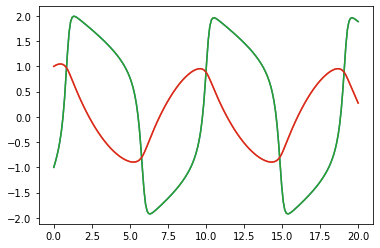

In [4]:
# Create some toy data
real_parameters = np.array(pints_model.suggested_parameters(), dtype='float64')
times = pints_model.suggested_times()
pints_values = pints_model.simulate(real_parameters, times)
autograd_values = autograd_model.simulate(real_parameters, times)

plt.figure()
plt.plot(times, autograd_values)
plt.plot(times, pints_values)
plt.show()

Add some noise to the values, and then create log-likelihoods using both the new model, and the pints model

In [5]:
noise = 0.1
values = pints_values + np.random.normal(0, noise, pints_values.shape)

# Create an object with links to the model and time series
autograd_problem = pints.MultiOutputProblem(autograd_model, times, values)
pints_problem = pints.MultiOutputProblem(pints_model, times, values)

# Create a log-likelihood function
autograd_log_likelihood = pints.GaussianKnownSigmaLogLikelihood(autograd_problem, noise)
autograd_likelihood = AutoGradLogLikelihood(autograd_log_likelihood)
pints_log_likelihood = pints.GaussianKnownSigmaLogLikelihood(pints_problem, noise)

We can calculate the gradients of both likelihood functions at the given parameters to make sure that they are the same

In [6]:
autograd_likelihood.evaluateS1(real_parameters)

(369.5127431705977, array([1278.50348645, 1043.41582511,  908.49197428]))

In [7]:
pints_log_likelihood.evaluateS1(real_parameters)

(369.51292685246295, array([1278.47284308, 1043.38969978,  908.46353422]))

Now we'll time both functions. You can see that the function using `autgrad` is significantly slower than the in-built `evaluateS1` function for the PINTS model, which calculates the sensitivities analytically.

In [8]:
statement = 'autograd_likelihood.evaluateS1(real_parameters)'
setup = 'from __main__ import autograd_likelihood, real_parameters'

time_taken = min(repeat(stmt=statement, setup=setup, number=1, repeat=5))

'Elapsed time: {:.0f} ms'.format(1000. * time_taken)

'Elapsed time: 5439 ms'

In [9]:
statement = 'pints_log_likelihood.evaluateS1(real_parameters)'
setup = 'from __main__ import pints_log_likelihood, real_parameters'

time_taken = min(repeat(stmt=statement, setup=setup, number=1, repeat=5))

'Elapsed time: {:.0f} ms'.format(1000. * time_taken)

'Elapsed time: 45 ms'